In [1]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.stats import gaussian_kde as kde
import matplotlib.pyplot as plt
import MDAnalysis as mda

In [2]:
u = mda.Universe('testing/run.gro','trajs/centered_trajectory_dcd.xtc')
protein = u.select_atoms('protein')
halfz = u.dimensions[2] / 2

In [5]:
 pl = u.select_atoms('resname POPC DOPE SAPI and name P and not around 10 protein and prop z < %f' % halfz, updating=True)

In [6]:
pl

<AtomGroup with 241 atoms, with selection 'resname POPC DOPE SAPI and name P and not around 10 protein and prop z < 115.103394' on the entire Universe.>

In [12]:

def calculate_center_of_mass(protein):
    return np.mean(protein.positions, axis=0)

def select_phospholipid_atoms(u, halfz):
    pl = u.select_atoms('resname POPC DOPE SAPI and name P and around 10 protein and prop z < %f' % halfz, updating=True)
    #### need to update the above for different systems depening if binding to top or bottom
    print(len(pl))
    return(pl)

def calculate_average_z(LP):
    return np.mean(LP.positions[:, 2])

In [13]:
def identify_defect_atoms(protein, defect_threshold):
    mask = protein.positions[:, 2] > defect_threshold
    ### need to adjust mask to account for if protein binds to top or bottom of membrane
    return protein[mask]

def calculate_defect_area_volume(defect_protein):
    defect_vol = ConvexHull(defect_protein.positions).volume
    defect_area = ConvexHull(defect_protein.positions[:, :2]).area
    return defect_area, defect_vol

def plot_hull(defect_protein_xy, ts):
    hull = ConvexHull(defect_protein_xy)
    plt.figure()
    for simplex in hull.simplices:
        plt.plot(defect_protein_xy[simplex, 0], defect_protein_xy[simplex, 1], 'k-')
    plt.title(f'Convex Hull at frame {ts.frame}')
    plt.show()

In [14]:
def generate_heatmap(all_points, u):
    k = kde([all_points[:, 0], all_points[:, 1]])
    xi, yi = np.mgrid[0:u.dimensions[0]:1000j, 0:u.dimensions[1]:1000j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # Define your threshold here
    threshold = 0.000001

    # Adjust zi according to the threshold
    zi_adj = np.where(zi > threshold, zi, np.nan)

    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap='jet', vmax=0.003, vmin=0.0003)
    plt.colorbar(label='Density')
    plt.xlim(0, u.dimensions[0])
    plt.ylim(0, u.dimensions[1])
    plt.xlabel('x (Å)')
    plt.ylabel('y (Å)')
    plt.title('Packing defect density heat map')
    plt.savefig('packing_density_DCD.png',dpi=400)
    plt.show()


In [15]:
def main():
    ls = []
    all_points = []
    centering_translation = calculate_center_of_mass(protein)
    for ts in u.trajectory:
        halfz = u.dimensions[2] / 2
        LP = select_phospholipid_atoms(u,  halfz)
        average_z = calculate_average_z(LP)
        defect_threshold = average_z 
        defect_protein = identify_defect_atoms(protein, defect_threshold)
        defect_protein_xy = defect_protein.positions[:, :2]
        if defect_protein.n_atoms >= 10:
            defect_area, defect_vol = calculate_defect_area_volume(defect_protein)
            ls.append(defect_area)
            hull = ConvexHull(defect_protein_xy)
            all_points.extend(defect_protein_xy[simplex] for simplex in hull.simplices)
    all_points = np.concatenate(all_points)
    generate_heatmap(all_points, u)
    return(ls)

29
30
31
30
28
28
29
31
32
29
30
33
29
28
29
27
29
25
26
24
25
26
28
25
30
28
29
33
30
30
32
29
28
31
30
27
27
27
28
28
26
26
27
25
26
27
28
28
26
27
28
27
24
28
21
22
26
22
29
24
24
24
25
21
19
19
17
16
19
18
16
20
19
17
18
20
19
17
21
19
21
21
20
22
22
20
18
22
20
19
18
19
19
19
19
21
21
20
19
19
17
20
21
17
18
22
18
20
21
20
20
20
18
19
19
21
20
22
21
20
19
20
20
20
16
18
17
19
20
21
21
19
19
18
20
19
20
20
18
19
18
19
19
21
20
20
21
20
18
19
20
21
21
19
20
22
20
21
20
21
23
19
21
22
20
20
21
21
22
23
22
25
22
24
20
19
24
23
24
26
27
22
26
26
26
27
27
27
26
25
25
22
25
25
25
28
27
26
27
26
24
26
26
26
27
28
27
26
26
27
25
23
24
24
23
23
26
22
22
19
20
22
23
22
22
24
21
22
20
23
22
21
22
25
23
27
22
22
20
25
23
22
23
23
23
24
25
21
21
24
22
24
22
22
25
21
22
21
18
21
22
22
22
24
24
26
24
22
22
25
22
22
20
18
19
20
21
20
21
20
22
19
22
20
21
22
19
20
20
23
20
20
20
21
21
20
25
23
24
21
20
23
22
21
23
20
18
18
21
22
23
20
20
22
22
21
23
22
22
22
22
24
23
25
21
23
24
19
21
22
22
23
22
2

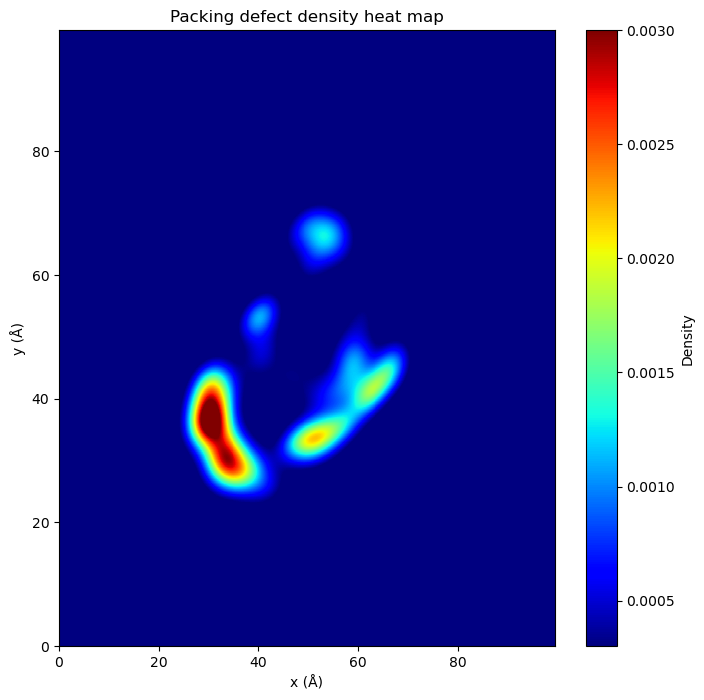

In [16]:
defect_areas_mlx = main()

In [104]:
np.average(defect_areas_dcd)

92.23318444287098

In [105]:
np.std(defect_areas_dcd)

17.53052434043826

In [102]:
np.average(defect_areas_mlx)

63.89832377575827

In [103]:
np.std(defect_areas_mlx)

16.258864924173487

Defect area at frame 0: 22.88940563518562
Defect area at frame 0: 22.88940563518562 Å²
Not enough points to calculate defect area at frame 1
Not enough points to calculate defect area at frame 2
Defect area at frame 3: 53.73195712142949
Defect area at frame 3: 53.73195712142949 Å²
Defect area at frame 4: 27.526852690615236
Defect area at frame 4: 27.526852690615236 Å²
Defect area at frame 5: 44.00868171634305
Defect area at frame 5: 44.00868171634305 Å²
Defect area at frame 6: 25.00916863494485
Defect area at frame 6: 25.00916863494485 Å²
Not enough points to calculate defect area at frame 7
Not enough points to calculate defect area at frame 8
Not enough points to calculate defect area at frame 9
Defect area at frame 10: 59.227874977720816
Defect area at frame 10: 59.227874977720816 Å²
Defect area at frame 11: 47.143324010556405
Defect area at frame 11: 47.143324010556405 Å²
Defect area at frame 12: 79.60414569367421
Defect area at frame 12: 79.60414569367421 Å²
Defect area at frame 1

Not enough points to calculate defect area at frame 100
Not enough points to calculate defect area at frame 101
Defect area at frame 102: 65.93444091235013
Defect area at frame 102: 65.93444091235013 Å²
Not enough points to calculate defect area at frame 103
Not enough points to calculate defect area at frame 104
Not enough points to calculate defect area at frame 105
Defect area at frame 106: 52.650518303517856
Defect area at frame 106: 52.650518303517856 Å²
Defect area at frame 107: 59.27839285418689
Defect area at frame 107: 59.27839285418689 Å²
Defect area at frame 108: 63.327723949056946
Defect area at frame 108: 63.327723949056946 Å²
Not enough points to calculate defect area at frame 109
Defect area at frame 110: 46.079972645344036
Defect area at frame 110: 46.079972645344036 Å²
Not enough points to calculate defect area at frame 111
Defect area at frame 112: 19.527195703886242
Defect area at frame 112: 19.527195703886242 Å²
Defect area at frame 113: 54.04866720182113
Defect are

Defect area at frame 208: 72.49646075090024
Defect area at frame 208: 72.49646075090024 Å²
Defect area at frame 209: 73.7676265996017
Defect area at frame 209: 73.7676265996017 Å²
Defect area at frame 210: 70.37967444873362
Defect area at frame 210: 70.37967444873362 Å²
Defect area at frame 211: 67.21204940854217
Defect area at frame 211: 67.21204940854217 Å²
Defect area at frame 212: 82.65064870279465
Defect area at frame 212: 82.65064870279465 Å²
Defect area at frame 213: 81.22042065919882
Defect area at frame 213: 81.22042065919882 Å²
Defect area at frame 214: 80.40515422472123
Defect area at frame 214: 80.40515422472123 Å²
Defect area at frame 215: 73.81513371919083
Defect area at frame 215: 73.81513371919083 Å²
Defect area at frame 216: 81.97605890697437
Defect area at frame 216: 81.97605890697437 Å²
Defect area at frame 217: 71.29483684472737
Defect area at frame 217: 71.29483684472737 Å²
Defect area at frame 218: 78.12417234645514
Defect area at frame 218: 78.12417234645514 Å²
D

Defect area at frame 308: 46.82352996697526
Defect area at frame 308: 46.82352996697526 Å²
Defect area at frame 309: 22.108290799723356
Defect area at frame 309: 22.108290799723356 Å²
Defect area at frame 310: 24.3264594955911
Defect area at frame 310: 24.3264594955911 Å²
Defect area at frame 311: 33.72910825250677
Defect area at frame 311: 33.72910825250677 Å²
Defect area at frame 312: 46.29821871814501
Defect area at frame 312: 46.29821871814501 Å²
Defect area at frame 313: 68.97546316046295
Defect area at frame 313: 68.97546316046295 Å²
Defect area at frame 314: 30.57739680864647
Defect area at frame 314: 30.57739680864647 Å²
Defect area at frame 315: 63.346253235054164
Defect area at frame 315: 63.346253235054164 Å²
Not enough points to calculate defect area at frame 316
Defect area at frame 317: 59.094218819358616
Defect area at frame 317: 59.094218819358616 Å²
Defect area at frame 318: 58.07501293616799
Defect area at frame 318: 58.07501293616799 Å²
Not enough points to calculate

Defect area at frame 405: 75.34981645012091
Defect area at frame 405: 75.34981645012091 Å²
Defect area at frame 406: 62.11081659496108
Defect area at frame 406: 62.11081659496108 Å²
Defect area at frame 407: 72.17638244632035
Defect area at frame 407: 72.17638244632035 Å²
Defect area at frame 408: 74.20995088888193
Defect area at frame 408: 74.20995088888193 Å²
Not enough points to calculate defect area at frame 409
Defect area at frame 410: 48.255815686343865
Defect area at frame 410: 48.255815686343865 Å²
Defect area at frame 411: 62.15257272102597
Defect area at frame 411: 62.15257272102597 Å²
Defect area at frame 412: 79.005146238143
Defect area at frame 412: 79.005146238143 Å²
Defect area at frame 413: 83.62262775343889
Defect area at frame 413: 83.62262775343889 Å²
Defect area at frame 414: 83.9670505353607
Defect area at frame 414: 83.9670505353607 Å²
Defect area at frame 415: 84.3515203026441
Defect area at frame 415: 84.3515203026441 Å²
Defect area at frame 416: 78.57406172275

Defect area at frame 528: 62.1382650717447
Defect area at frame 528: 62.1382650717447 Å²
Defect area at frame 529: 59.55932031183268
Defect area at frame 529: 59.55932031183268 Å²
Defect area at frame 530: 79.73608661435252
Defect area at frame 530: 79.73608661435252 Å²
Defect area at frame 531: 24.75847790943004
Defect area at frame 531: 24.75847790943004 Å²
Defect area at frame 532: 81.20046774924461
Defect area at frame 532: 81.20046774924461 Å²
Defect area at frame 533: 73.16767930534328
Defect area at frame 533: 73.16767930534328 Å²
Defect area at frame 534: 81.50781652257469
Defect area at frame 534: 81.50781652257469 Å²
Defect area at frame 535: 74.21851974047566
Defect area at frame 535: 74.21851974047566 Å²
Defect area at frame 536: 83.35860106546356
Defect area at frame 536: 83.35860106546356 Å²
Defect area at frame 537: 82.2598399491391
Defect area at frame 537: 82.2598399491391 Å²
Defect area at frame 538: 64.74903391751947
Defect area at frame 538: 64.74903391751947 Å²
Def

Defect area at frame 625: 76.17730380564403
Defect area at frame 625: 76.17730380564403 Å²
Defect area at frame 626: 82.73596330187233
Defect area at frame 626: 82.73596330187233 Å²
Defect area at frame 627: 86.90453997622632
Defect area at frame 627: 86.90453997622632 Å²
Defect area at frame 628: 72.56448996599504
Defect area at frame 628: 72.56448996599504 Å²
Defect area at frame 629: 84.65155460209935
Defect area at frame 629: 84.65155460209935 Å²
Defect area at frame 630: 83.36996103447692
Defect area at frame 630: 83.36996103447692 Å²
Defect area at frame 631: 83.59773963930711
Defect area at frame 631: 83.59773963930711 Å²
Defect area at frame 632: 82.82018826573372
Defect area at frame 632: 82.82018826573372 Å²
Defect area at frame 633: 91.24510395343754
Defect area at frame 633: 91.24510395343754 Å²
Defect area at frame 634: 94.30493900472382
Defect area at frame 634: 94.30493900472382 Å²
Defect area at frame 635: 91.59265639929806
Defect area at frame 635: 91.59265639929806 Å²

Defect area at frame 719: 69.79934139720197
Defect area at frame 719: 69.79934139720197 Å²
Defect area at frame 720: 20.66363416842652
Defect area at frame 720: 20.66363416842652 Å²
Not enough points to calculate defect area at frame 721
Not enough points to calculate defect area at frame 722
Defect area at frame 723: 64.04629862637127
Defect area at frame 723: 64.04629862637127 Å²
Defect area at frame 724: 53.17540358478138
Defect area at frame 724: 53.17540358478138 Å²
Defect area at frame 725: 58.69276742074251
Defect area at frame 725: 58.69276742074251 Å²
Defect area at frame 726: 21.21265714586111
Defect area at frame 726: 21.21265714586111 Å²
Defect area at frame 727: 63.44829662863605
Defect area at frame 727: 63.44829662863605 Å²
Defect area at frame 728: 81.92054581026446
Defect area at frame 728: 81.92054581026446 Å²
Defect area at frame 729: 78.95604013071896
Defect area at frame 729: 78.95604013071896 Å²
Defect area at frame 730: 18.173241140395806
Defect area at frame 730

Defect area at frame 819: 67.11371342846014
Defect area at frame 819: 67.11371342846014 Å²
Defect area at frame 820: 79.43615477122208
Defect area at frame 820: 79.43615477122208 Å²
Defect area at frame 821: 67.85808112533448
Defect area at frame 821: 67.85808112533448 Å²
Defect area at frame 822: 69.57912590844013
Defect area at frame 822: 69.57912590844013 Å²
Defect area at frame 823: 54.46306535553418
Defect area at frame 823: 54.46306535553418 Å²
Not enough points to calculate defect area at frame 824
Defect area at frame 825: 47.17762861497385
Defect area at frame 825: 47.17762861497385 Å²
Defect area at frame 826: 48.2593714747428
Defect area at frame 826: 48.2593714747428 Å²
Defect area at frame 827: 60.40526459109492
Defect area at frame 827: 60.40526459109492 Å²
Defect area at frame 828: 53.48202422211736
Defect area at frame 828: 53.48202422211736 Å²
Defect area at frame 829: 57.54916866270196
Defect area at frame 829: 57.54916866270196 Å²
Defect area at frame 830: 76.1265705

Defect area at frame 912: 64.17080253282536
Defect area at frame 912: 64.17080253282536 Å²
Defect area at frame 913: 38.14079208775393
Defect area at frame 913: 38.14079208775393 Å²
Defect area at frame 914: 67.7815655083314
Defect area at frame 914: 67.7815655083314 Å²
Defect area at frame 915: 65.38473497131378
Defect area at frame 915: 65.38473497131378 Å²
Defect area at frame 916: 49.70178439561131
Defect area at frame 916: 49.70178439561131 Å²
Defect area at frame 917: 71.28990141742973
Defect area at frame 917: 71.28990141742973 Å²
Defect area at frame 918: 62.398078592734365
Defect area at frame 918: 62.398078592734365 Å²
Defect area at frame 919: 80.06314232418649
Defect area at frame 919: 80.06314232418649 Å²
Defect area at frame 920: 65.12074744177349
Defect area at frame 920: 65.12074744177349 Å²
Defect area at frame 921: 73.00017529013331
Defect area at frame 921: 73.00017529013331 Å²
Defect area at frame 922: 52.22983433214299
Defect area at frame 922: 52.22983433214299 Å²

/tmp/ipykernel_27738/2825335223.py:41: RuntimeWarning: invalid value encountered in divide
  average_depths = np.where(depth_counts != 0, depth_sums / depth_counts, np.nan)


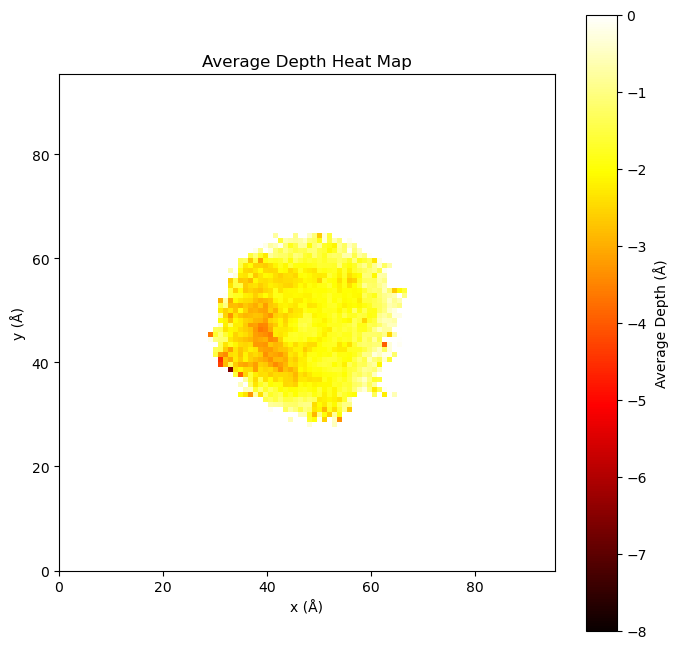

In [46]:
ls = []
all_points = []
depth_sums = np.zeros((100, 100))
depth_counts = np.zeros((100, 100), dtype=int)

for ts in u.trajectory:
    halfz = u.dimensions[2] / 2
    LP = u.select_atoms('resname POPC DOPE SAPI and name P and around 10 protein and prop z > %f' % halfz, updating=True)
    average_z = np.mean(LP.positions[:, 2])
    defect_threshold = average_z

    mask = protein.positions[:, 2] < defect_threshold
    defect_protein = protein[mask]
    defect_protein_xy = defect_protein.positions[:, :2]

    if defect_protein.n_atoms >= 10:
        defect_vol = ConvexHull(defect_protein.positions).volume
        defect_area = ConvexHull(defect_protein_xy).area
        ls.append(defect_area)
        print(f"Defect area at frame {ts.frame}: {defect_area}")

        hull = ConvexHull(defect_protein_xy)
        defect_area = hull.area
        print(f"Defect area at frame {ts.frame}: {defect_area} Å²")

        for simplex in hull.simplices:
            all_points.append(defect_protein_xy[simplex])

        for i in range(defect_protein.n_atoms):
            x_bin = int(defect_protein.positions[i, 0] / u.dimensions[0] * 100)
            y_bin = int(defect_protein.positions[i, 1] / u.dimensions[1] * 100)
            
            # Adjusted depth calculation: difference between average_z and protein's z-coordinate
#             depth = average_z - defect_protein.positions[i, 2]
            depth =  defect_protein.positions[i, 2] - average_z
            depth_sums[x_bin, y_bin] += depth
            depth_counts[x_bin, y_bin] += 1
    else:
        print(f"Not enough points to calculate defect area at frame {ts.frame}")

average_depths = np.where(depth_counts != 0, depth_sums / depth_counts, np.nan)

plt.figure(figsize=(8, 8))
plt.imshow(average_depths.T, origin='lower', extent=(0, u.dimensions[0], 0, u.dimensions[1]), cmap='hot',vmin=-8, vmax=0)
plt.colorbar(label='Average Depth (Å)')
plt.xlabel('x (Å)')
plt.ylabel('y (Å)')
plt.title('Average Depth Heat Map')
plt.savefig('depth_mlx.png', dpi=400)
plt.show()


In [41]:
np.sum(depth_sums)

134241.24978637695

In [42]:
np.shape(depth_sums)

(100, 100)

In [43]:
nonzero_depth_sums = depth_sums[depth_sums != 0]

In [44]:
np.shape(nonzero_depth_sums)

(1091,)

In [45]:
nonzero_depth_sums[101]

7.67926025390625

In [110]:
np.sum(nonzero_depth_sums)/len(nonzero_depth_sums)

-286.74188713954834

In [116]:
np.average(nonzero_depth_sums)

-286.74188713954834

In [118]:
s=np.array([1,2,3,4,5,6,7,8,9,10])

In [120]:
np.average(s)

5.5

In [123]:

average_depths = np.where(depth_counts != 0, depth_sums / depth_counts, np.nan)

/tmp/ipykernel_539/1864772504.py:1: RuntimeWarning: invalid value encountered in divide
  average_depths = np.where(depth_counts != 0, depth_sums / depth_counts, np.nan)
